In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
back_test_df= pd.read_csv('./backtest_30/back_test_0920_30.csv')
kodex_df = pd.read_csv('./backtest_20/kodex_return.csv')

In [50]:
# 백테스트 날짜와 함께 결과 DataFrame 생성
def backtest(y_pred, y_test, dates) :
    results_df = pd.DataFrame({
        'date': dates[-len(y_pred):],  # 테스트 세트와 동일한 길이의 날짜 데이터
        'y_test': y_test.values,  # y_test를 1차원 배열로 변환
        'y_pred': y_pred  # y_pred는 이미 1차원 배열임
    })
    results_df.set_index('date', inplace=True)
    backtest_open = pd.read_csv('./backtest/kodex_open.csv')
    backtest_open['date'] = pd.to_datetime(backtest_open['date'],format= "%Y%m%d")
    backtest_open.set_index('date', inplace=True)
    back_test_df = pd.merge(results_df,backtest_open, right_index=True,left_index=True, how='inner')
    return back_test_df
    

In [51]:
def backtest_concat(back_test_df, kodex_df) :
    # 'date' 컬럼의 데이터 형식을 일치시키기 위해 kodex 데이터의 'date'를 문자열로 변환
    kodex_df['date'] = pd.to_datetime(kodex_df['date'].astype(str), format='%Y%m%d')

    # back_test 데이터의 'date'도 datetime 객체로 변환
    back_test_df['date'] = pd.to_datetime(back_test_df['date'])

    # 두 데이터 프레임을 'date'를 기준으로 병합
    merged_backtest = pd.merge(back_test_df, kodex_df, on='date', how='inner')

    # 결과 확인
    return merged_backtest

merged_backtest = backtest_concat(back_test_df, kodex_df)

In [52]:
def backtest_strategy_with_commission_filter(df, commission=0.02):
    """
    Execute a backtesting strategy based on predicted and actual open prices, considering commission.

    Parameters:
    df (DataFrame): The dataframe with columns 'open', 'y_pred', and 'y_test'.
    commission (float): The commission rate for the transactions.

    Returns:
    DataFrame: The dataframe with the backtesting results including cumulative profit and total real profit.
    """
    # Calculate the profit/loss for both long and short positions
    df['profit_long'] = (df['y_pred'] - df['open'] * (1 + commission)) / df['open']
    df['profit_short'] = (df['open'] * (1 - commission) - df['y_pred']) / df['open']
    
    # Apply the real profit considering the commission and only execute if the expected profit is greater than commission
    df['real_profit_long'] = df.apply(
        lambda row: (row['y_test'] - row['open'] * (1 + commission)) / row['open'] if row['profit_long'] > commission else 0,
        axis=1
    )
    df['real_profit_short'] = df.apply(
        lambda row: (row['open'] * (1 - commission) - row['y_test']) / row['open'] if row['profit_short'] > commission else 0,
        axis=1
    )
    
    # Apply the real profit considering the actual transaction and the commission filter
    df['real_profit'] = df.apply(
        lambda row: row['real_profit_long'] if row['profit_long'] > commission else (row['real_profit_short'] if row['profit_short'] > commission else 0),
        axis=1
    )
    
    # Calculate the cumulative profit
    df['cumulative_profit'] = (1 + df['real_profit']).cumprod() - 1
    
    # Add a column for the total real profit
    df['total_real_profit'] = df['real_profit'].cumsum()
    # 누적 수익률 계산 (1 + r_t).cumprod()를 사용하여 각 시점의 누적 곱을 계산

    df['kodex_cumulative_return'] = (1 + df['kodex_return'].fillna(0)).cumprod() - 1


    
    # Return the relevant columns
    return df[['date', 'open', 'y_pred', 'y_test', 'profit_long', 'profit_short', 'real_profit_long', 'real_profit_short', 'real_profit', 'cumulative_profit', 'total_real_profit','kodex_cumulative_return']]

# Run the backtest strategy function with commission filter on the loaded dataframe
backtest_results = backtest_strategy_with_commission_filter(merged_backtest)

# Display the first few rows of the backtesting results with commission filter
backtest_results.tail(20)

## 백테스트 결과 저장
# backtest_results.to_csv('./backtest_result/lr_0910_30.csv')

,date,open,y_pred,y_test,profit_long,profit_short,real_profit_long,real_profit_short,real_profit,cumulative_profit,total_real_profit,kodex_cumulative_return
340,2023-09-21,33005.0,33883.736795,33910.0,0.006624,-0.046624,0.0,0.0,0.0,0.049376,0.048948,-0.031478
341,2023-09-22,33105.0,33684.914644,33765.0,-0.002483,-0.037517,0.0,0.0,0.0,0.049376,0.048948,-0.028544
342,2023-09-25,33230.0,32987.831150,33010.0,-0.027288,-0.012712,0.0,0.0,0.0,0.049376,0.048948,-0.024876
343,2023-09-26,32620.0,33092.046368,33125.0,-0.005529,-0.034471,0.0,0.0,0.0,0.049376,0.048948,-0.042776
344,2023-09-27,32480.0,33197.860928,33060.0,0.002102,-0.042102,0.0,0.0,0.0,0.049376,0.048948,-0.046884
345,2023-10-04,32235.0,32610.796500,32810.0,-0.008342,-0.031658,0.0,0.0,0.0,0.049376,0.048948,-0.054074
346,2023-10-05,32060.0,32464.679333,32175.0,-0.007377,-0.032623,0.0,0.0,0.0,0.049376,0.048948,-0.059209
347,2023-10-06,32405.0,32221.348970,32120.0,-0.025667,-0.014333,0.0,0.0,0.0,0.049376,0.048948,-0.049085
348,2023-10-10,32595.0,32065.026062,32135.0,-0.036259,-0.003741,0.0,0.0,0.0,0.049376,0.048948,-0.043510
349,2023-10-11,32865.0,32377.066800,32550.0,-0.034847,-0.005153,0.0,0.0,0.0,0.049376,0.048948,-0.035587


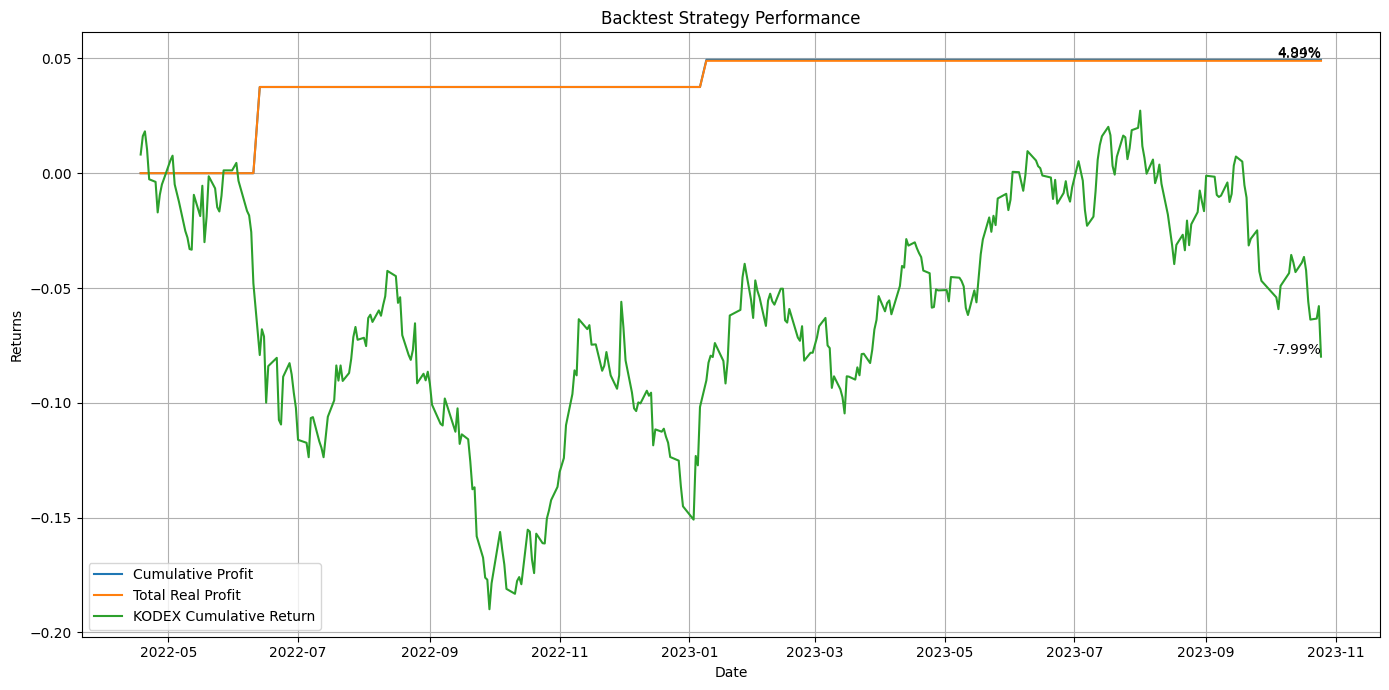

In [53]:
import matplotlib.pyplot as plt

# 그래프에 'cumulative_profit', 'total_real_profit', 'kodex_cumulative_return'의 마지막 값을 표시합니다.
plt.figure(figsize=(14, 7))

# 'cumulative_profit' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'cumulative_profit' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['cumulative_profit'], label='Cumulative Profit')
    last_value = backtest_results['cumulative_profit'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 'total_real_profit' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'total_real_profit' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['total_real_profit'], label='Total Real Profit')
    last_value = backtest_results['total_real_profit'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 'kodex_cumulative_return' 컬럼을 선으로 시각화하고 마지막 값을 표시합니다.
if 'kodex_cumulative_return' in backtest_results.columns:
    plt.plot(backtest_results['date'], backtest_results['kodex_cumulative_return'], label='KODEX Cumulative Return')
    last_value = backtest_results['kodex_cumulative_return'].iloc[-1]
    plt.text(backtest_results['date'].iloc[-1], last_value, f'{last_value:.2%}', va='bottom', ha='right')

# 제목 및 라벨 추가
plt.title('Backtest Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Returns')

# 범례 표시
plt.legend()

# 레이아웃 개선 및 그리드 추가
plt.tight_layout()
plt.grid(True)
plt.show()
